# Classification accuracy metrics for pixel based and object based classification

The schema for this analysis was adopted from the description of object-based statistics in
Caicedo et al. (2018) Evaluation of Deep Learning Strategies for Nucleus Segmentation
in Fluorescence Images. BioRxiv 335216.

The SEG metric was adapted from Maška et al. (2014). A benchmark for comparison of cell
tracking algorithms. Bioinformatics 30, 1609–1617.

The linear classification schema used to match objects in truth and prediction frames was
adapted from Jaqaman et al. (2008). Robust single-particle tracking in live-cell
time-lapse sequences. Nature Methods 5, 695–702.

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
from skimage.io import imshow

from skimage.measure import label

import deepcell.datasets
from deepcell import metrics

/usr/local/lib/python3.5/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


# Load data

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (5760, 216, 256, 1)
y.shape: (5760, 216, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [5]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

### Set up training parameters

In [6]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'conv_fgbg_model'
conv_model_name = 'conv_watershed_model'

n_epoch = 3  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'watershed'
distance_bins = 4
erosion_width = 0  # erode edges

# Instantiate model from saved weights

### First, create a foreground/background separation model

#### Instantiate the fgbg model

First instantiate a model from the deepcell `model_zoo`.

In [7]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=tuple(X_train.shape[1:]),
    last_only=False)

Compile the model and load weights from a previously trained model.

In [8]:
from tensorflow.keras.optimizers import SGD

fgbg_model.compile(SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),metrics=['accuracy'])
fgbg_model.load_weights('/data/models/conv_fgbg_model.h5')

### Next, Create a model for the watershed energy transform

#### Instantiate the distance transform model

In [9]:
from deepcell import model_zoo

watershed_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=tuple(X_train.shape[1:]))

In [10]:
from tensorflow.keras.optimizers import SGD

watershed_model.compile(SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),metrics=['accuracy'])
watershed_model.load_weights('/data/models/conv_watershed_model.h5')

# Generate predictions from test data

In [11]:
# make predictions on testing data
test_images = watershed_model.predict(X_test)[-1]
test_images_fgbg = fgbg_model.predict(X_test)[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (1440, 216, 256, 4)
segmentation mask shape: (1440, 216, 256, 2)


### Watershed post-processing

In [12]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

watershed argmax shape: (1440, 216, 256, 1)


In [13]:
# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [14]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=-1)

Visualize the image at each stage in processing.

Image number: 641


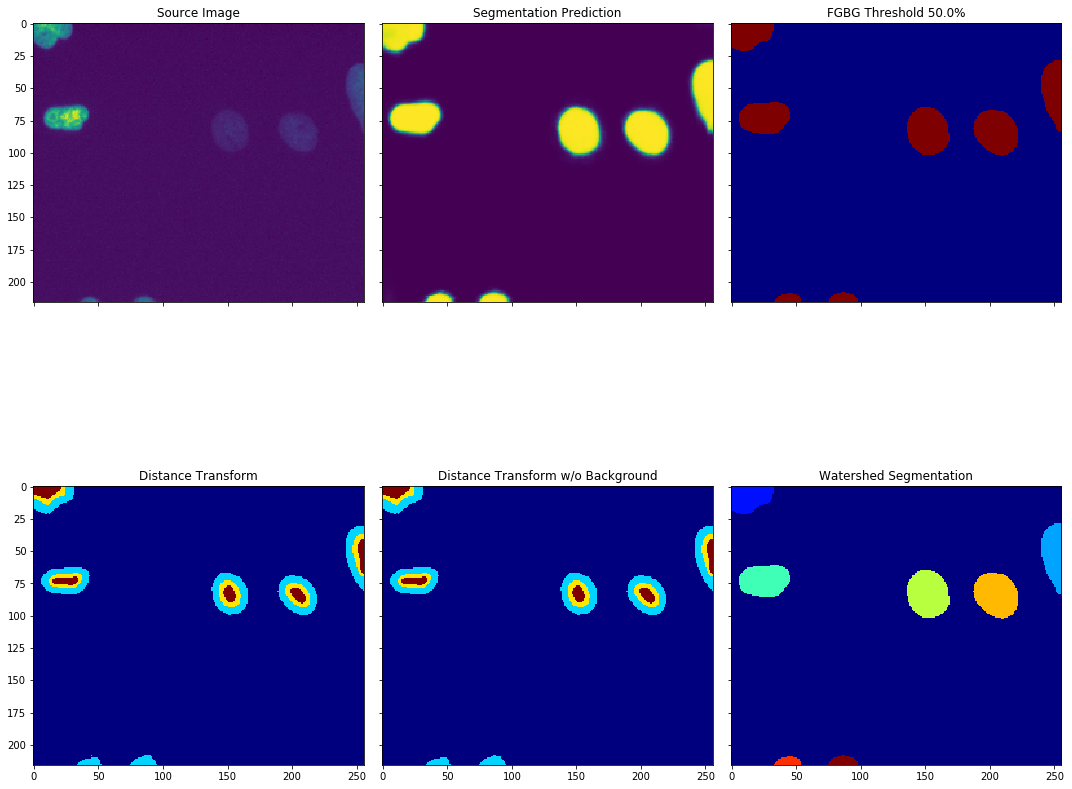

In [15]:
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(argmax_images[index, ..., 0], cmap='jet')
ax[3].set_title('Distance Transform')

ax[4].imshow(argmax_images_post_fgbg[index, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform w/o Background')

ax[5].imshow(watershed_images[index, ..., 0], cmap='jet')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()

# Run metrics on complete test set

In [17]:
%%time
m = metrics.Metrics('fgbg',seg=True)

y_true_lbl = y_test[:,:,:,0].astype('int')
y_pred_lbl = watershed_images[:,:,:,0]

m.calc_object_stats(y_true_lbl,y_pred_lbl)

INFO:tensorflow:0 samples processed
INFO:tensorflow:500 samples processed


/usr/local/lib/python3.5/dist-packages/deepcell/metrics.py:323: RuntimeWarning: Mean of empty slice
  correct_index[1]])


INFO:tensorflow:1000 samples processed

____________Object-based statistics____________

Number of true cells:		 10115
Number of predicted cells:	 10520

Correct detections:  9059	Recall: 89.56%
Incorrect detections: 1461	Precision: 86.11%

Gained detections: 1378	Perc Error: 58.14%
Missed detections: 920	Perc Error: 38.82%
Merges: 61		Perc Error: 2.574%
Splits: 8		Perc Error: 0.3376%
Catastrophes: 3		Perc Error: 0.1266%

Gained detections from splits: 8
Missed detections from merges: 61
True detections involved in catastrophes: 6
Predicted detections involved in catastrophes: 6 

SEG: 0.8197 

Average Pixel IOU (Jaccard Index): 0.7915 

CPU times: user 1min 13s, sys: 39.3 ms, total: 1min 13s
Wall time: 1min 13s


Note: pixel based statistics are also available from `m.all_pixel_stats`, but it requires that the ground truth annotation be transformed to match the features output by the model prediction.

Additionally, the final metric report can be saved using `m.save_to_json(m.output)` after object and/or pixel statistics have been generated.

Currently this dataset has small enough frame sizes that they can be looped over in `m.calc_object_stats` without too much of a problem. For datasets with larger frame sizes, the function `metrics.split_stack` can be used to reshape the data into a managable size.